In [53]:
#   Setup and Data Loading
import os
import matplotlib.pyplot as plt
import shutil
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import networkx as nx
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


# Create data directory and move files
os.makedirs('data', exist_ok=True)
shutil.move('barcodes.tsv', 'data/barcodes.tsv')
shutil.move('genes.tsv', 'data/genes.tsv')
shutil.move('matrix.mtx', 'data/matrix.mtx')

# Load 10X data
adata = sc.read_10x_mtx('data/', var_names='gene_symbols', cache=True)
print(adata)

AnnData object with n_obs × n_vars = 2237 × 33694
    var: 'gene_ids'


tissue
lesional        1237
non-lesional    1000
Name: count, dtype: int64


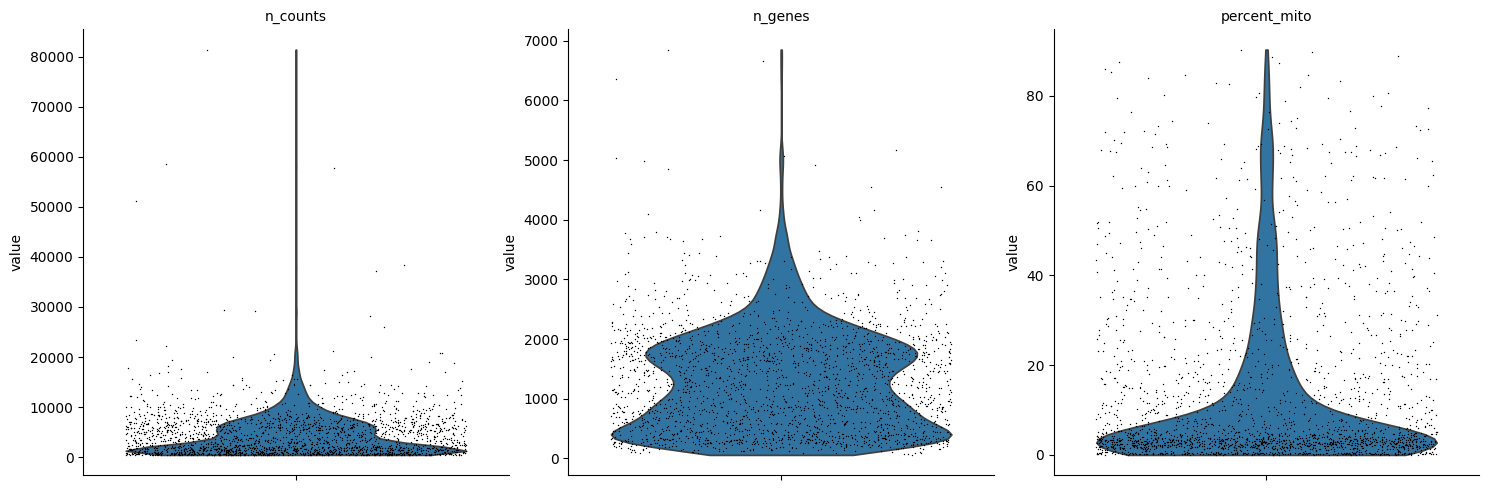

In [54]:
#   Tissue Annotation and QC Metrics
# Create tissue annotation based on barcode suffix
adata.obs['tissue'] = ['non-lesional' if barcode.endswith('-1') else 'lesional' for barcode in adata.obs_names]

# Check tissue distribution
print(adata.obs['tissue'].value_counts())

# Calculate QC metrics
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1

# Identify mitochondrial genes
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['percent_mito'] = (adata.X[:, mt_gene_mask].sum(axis=1).A1 / adata.obs['n_counts']) * 100

# Plot QC metrics
sc.pl.violin(adata, ['n_counts', 'n_genes', 'percent_mito'], jitter=0.4, multi_panel=True)

In [56]:
 # Filtering and Normalization
# Filter cells: keep cells with 200 < n_genes < 6000 and percent mito < 10%
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=6000)
adata = adata[adata.obs['percent_mito'] < 10, :]

# Filter genes: keep genes detected in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

print(f"After filtering: {adata.shape[0]} cells, {adata.shape[1]} genes")

# Normalize and log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Save raw normalized data
adata.raw = adata

C:\Users\harsh\anaconda3\Lib\site-packages\scanpy\preprocessing\_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After filtering: 1497 cells, 15396 genes


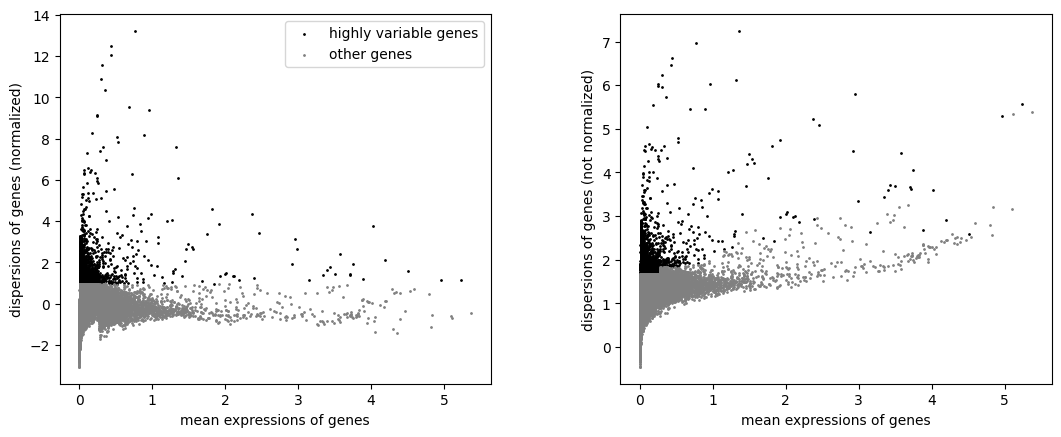

In [57]:
#   Highly Variable Genes
# Find highly variable genes
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)

# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

# Subset to highly variable genes
adata = adata[:, adata.var.highly_variable]
adata = adata.copy()

# Recompute QC metrics after filtering
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1

# Re-identify mitochondrial genes
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['percent_mito'] = (adata.X[:, mt_gene_mask].sum(axis=1).A1 / adata.obs['n_counts']) * 100

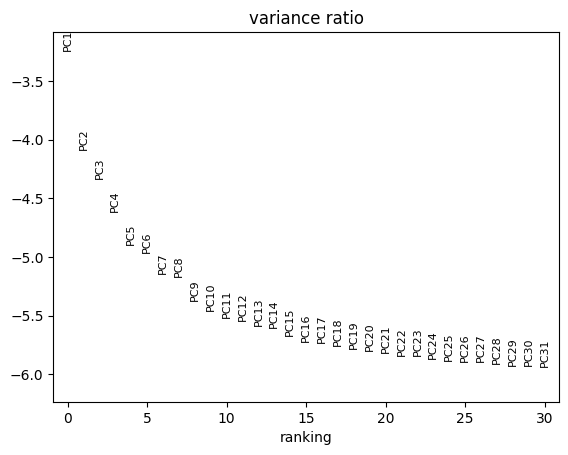

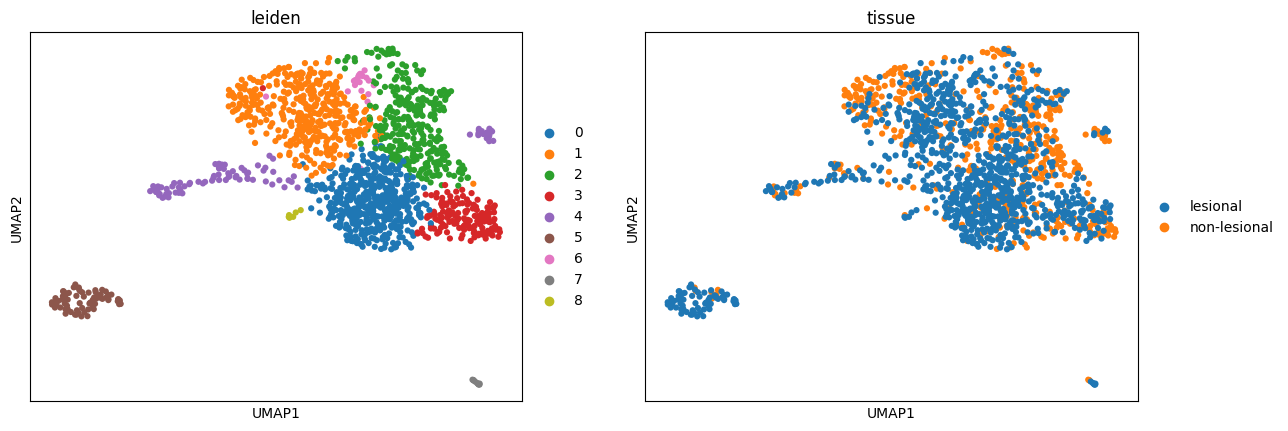

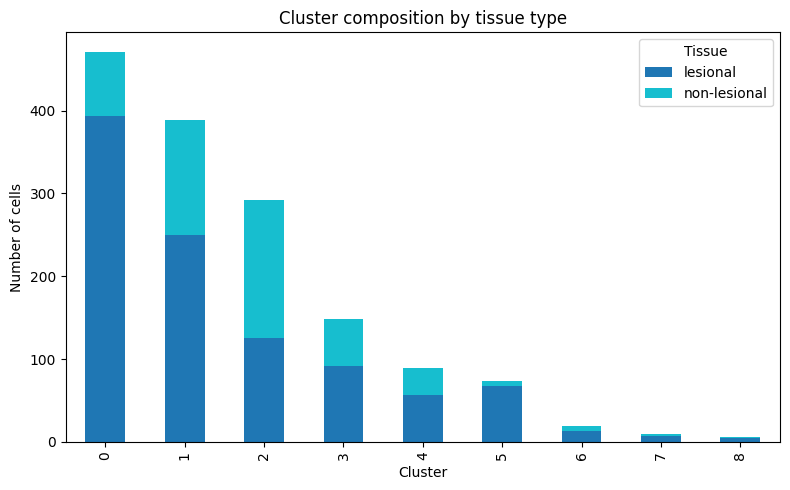

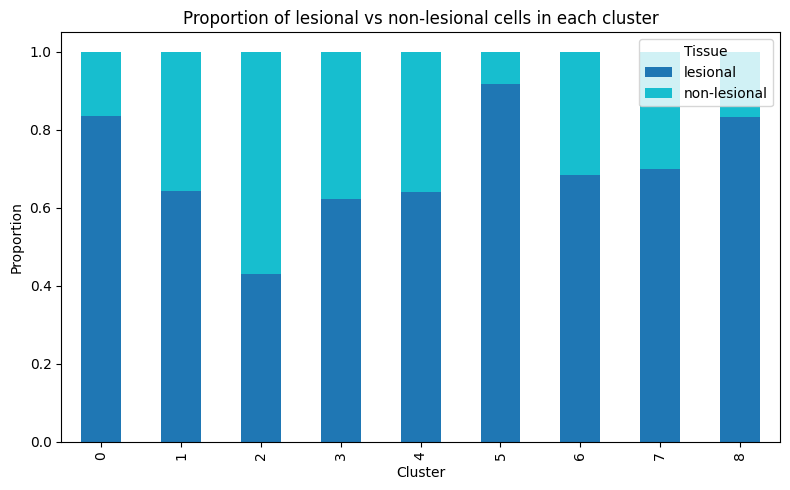

In [58]:
#   PCA and Clustering
# Regress out confounding factors and scale
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

# PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

# Compute neighbors and UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# Leiden clustering
sc.tl.leiden(adata, resolution=0.5)

# Plot UMAP colored by clusters and tissue type
sc.pl.umap(adata, color=['leiden', 'tissue'])
# Create a crosstab of cluster vs tissue
cluster_tissue_counts = pd.crosstab(adata.obs['leiden'], adata.obs['tissue'])

# Optional: Normalize by row to see proportions
cluster_tissue_props = pd.crosstab(adata.obs['leiden'], adata.obs['tissue'], normalize='index')

# Plot as stacked barplot (absolute counts)
cluster_tissue_counts.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='tab10')
plt.title('Cluster composition by tissue type')
plt.ylabel('Number of cells')
plt.xlabel('Cluster')
plt.legend(title='Tissue')
plt.tight_layout()
plt.show()

# Plot as proportions (optional)
cluster_tissue_props.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='tab10')
plt.title('Proportion of lesional vs non-lesional cells in each cluster')
plt.ylabel('Proportion')
plt.xlabel('Cluster')
plt.legend(title='Tissue')
plt.tight_layout()
plt.show()

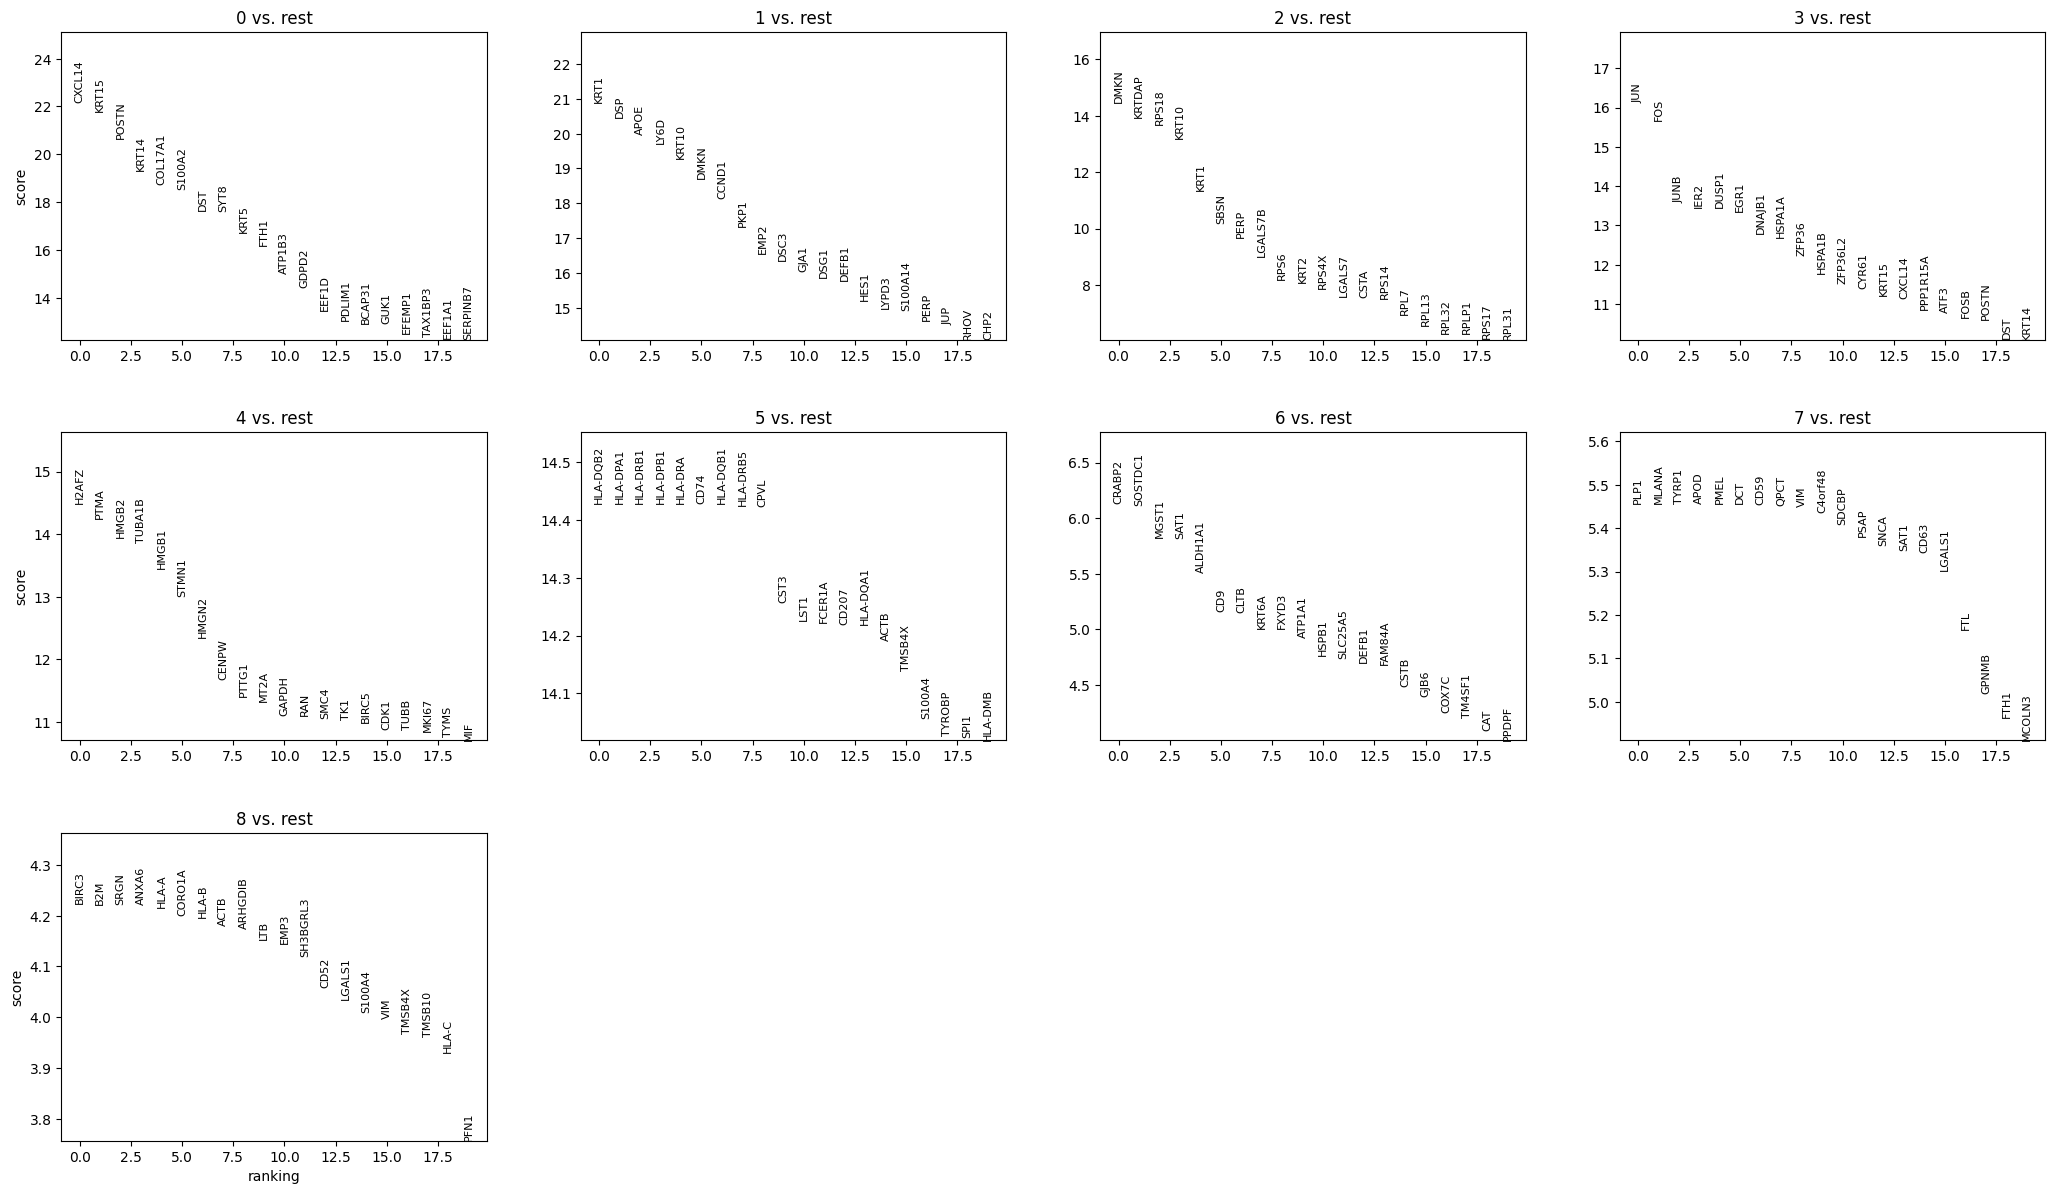

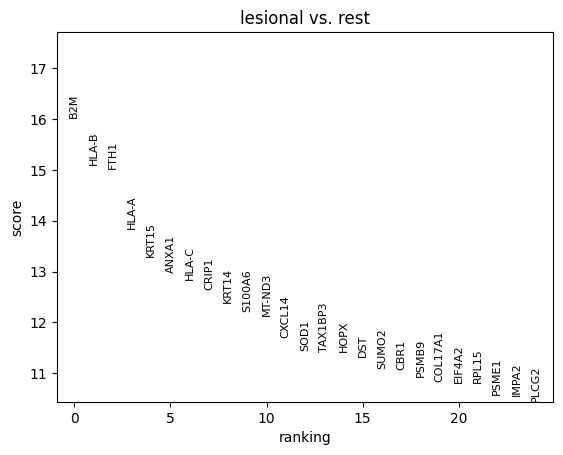

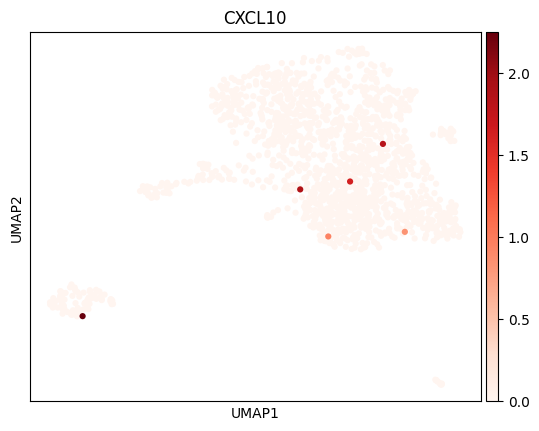

In [59]:
#   Differential Expression Analysis
# Find marker genes for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# Differential expression between tissue types
sc.tl.rank_genes_groups(adata, groupby='tissue', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, groups=['lesional'], reference='non-lesional')

# Check for cytokine expression
cytokines = ['IL2', 'IFNG', 'TNF', 'CXCL9', 'CXCL10', 'IL10', 'IL17A', 'IL6']
present_cytokines = [gene for gene in cytokines if gene in adata.var_names]

if present_cytokines:
    sc.pl.umap(adata, color=present_cytokines, cmap='Reds')

In [60]:
#   Define Vitiligo-Related Gene Sets
vitiligo_genes = {
    'th1_cytokines': ['IFNG', 'TNF', 'IL2', 'IL12A', 'IL12B'],
    'th17_cytokines': ['IL17A', 'IL17F', 'IL22', 'IL23A'],
    'regulatory_cytokines': ['IL10', 'TGFB1', 'IL35', 'FOXP3'],
    'cxcr3_chemokines': ['CXCL9', 'CXCL10', 'CXCL11'],
    'other_chemokines': ['CCL2', 'CCL5', 'CCL20', 'CXCL1', 'CXCL8'],
    'type1_interferon': ['IFNA1', 'IFNB1', 'ISG15', 'MX1', 'OAS1', 'STAT1'],
    'melanocyte_markers': ['TYR', 'TYRP1', 'DCT', 'MITF', 'PMEL', 'MLANA'],
    'stress_response': ['HSPA1A', 'HSPA1B', 'HSP90AA1', 'HSPA6', 'DNAJB1']
}

# Check for gene presence
available_genes = {}

print("Checking gene availability...")
for category, genes in vitiligo_genes.items():
    present = [g for g in genes if g in adata.var_names]
    missing = [g for g in genes if g not in adata.var_names]
    
    if present:
        available_genes[category] = present
        print(f"{category.upper()}: {len(present)}/{len(genes)} genes present")
        print(f"  Available: {', '.join(present)}")
        if missing:
            print(f"  Missing: {', '.join(missing)}")
    else:
        print(f"{category.upper()}: No genes found")
    print()

Checking gene availability...
TH1_CYTOKINES: No genes found

TH17_CYTOKINES: No genes found

REGULATORY_CYTOKINES: No genes found

CXCR3_CHEMOKINES: 1/3 genes present
  Available: CXCL10
  Missing: CXCL9, CXCL11

OTHER_CHEMOKINES: 4/5 genes present
  Available: CCL2, CCL5, CCL20, CXCL8
  Missing: CXCL1

TYPE1_INTERFERON: 1/6 genes present
  Available: ISG15
  Missing: IFNA1, IFNB1, MX1, OAS1, STAT1

MELANOCYTE_MARKERS: 6/6 genes present
  Available: TYR, TYRP1, DCT, MITF, PMEL, MLANA

STRESS_RESPONSE: 3/5 genes present
  Available: HSPA1A, HSPA6, DNAJB1
  Missing: HSPA1B, HSP90AA1



Scoring pathway gene sets...
✓ Calculated cxcr3_chemokines score
✓ Calculated other_chemokines score
✓ Calculated type1_interferon score
✓ Calculated melanocyte_markers score
✓ Calculated stress_response score


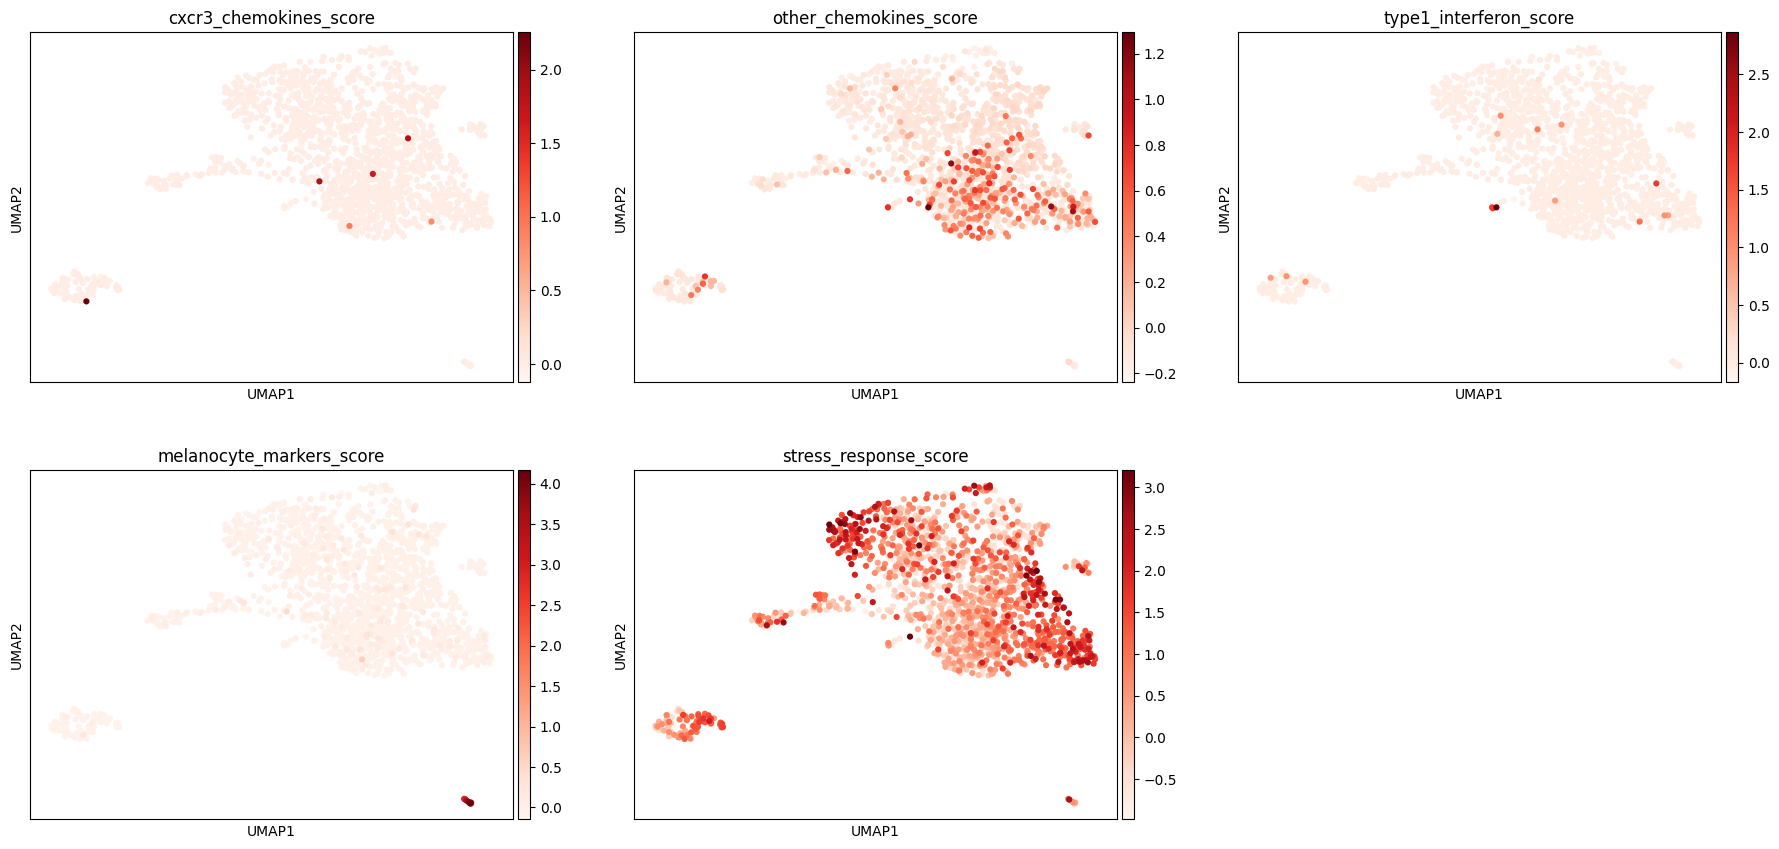

In [61]:
#   Pathway Scoring for Cytokine/Chemokine Activity
# Ensure UMAP is computed
if 'X_umap' not in adata.obsm:
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

# Score each gene set
print("Scoring pathway gene sets...")
for pathway, genes in available_genes.items():
    sc.tl.score_genes(adata, genes, score_name=f'{pathway}_score')
    print(f"✓ Calculated {pathway} score")

# Plot scores on UMAP (in batches of 6)
pathway_scores = [f"{pathway}_score" for pathway in available_genes]
for i in range(0, len(pathway_scores), 6):
    sc.pl.umap(adata, color=pathway_scores[i:i+6], ncols=3, cmap='Reds')

Scoring cell types...
✗ Skipped T_CD4 (no markers found)
✓ Scored T_CD8 (1 markers)
✗ Skipped T_reg (no markers found)
✓ Scored NK (1 markers)
✗ Skipped B_cells (no markers found)
✗ Skipped Plasma (no markers found)
✓ Scored Monocytes (2 markers)
✗ Skipped Macrophages (no markers found)
✓ Scored DC_myeloid (2 markers)
✗ Skipped DC_plasmacytoid (no markers found)
✓ Scored Keratinocytes (2 markers)
✓ Scored Melanocytes (3 markers)
✗ Skipped Fibroblasts (no markers found)
✗ Skipped Endothelial (no markers found)


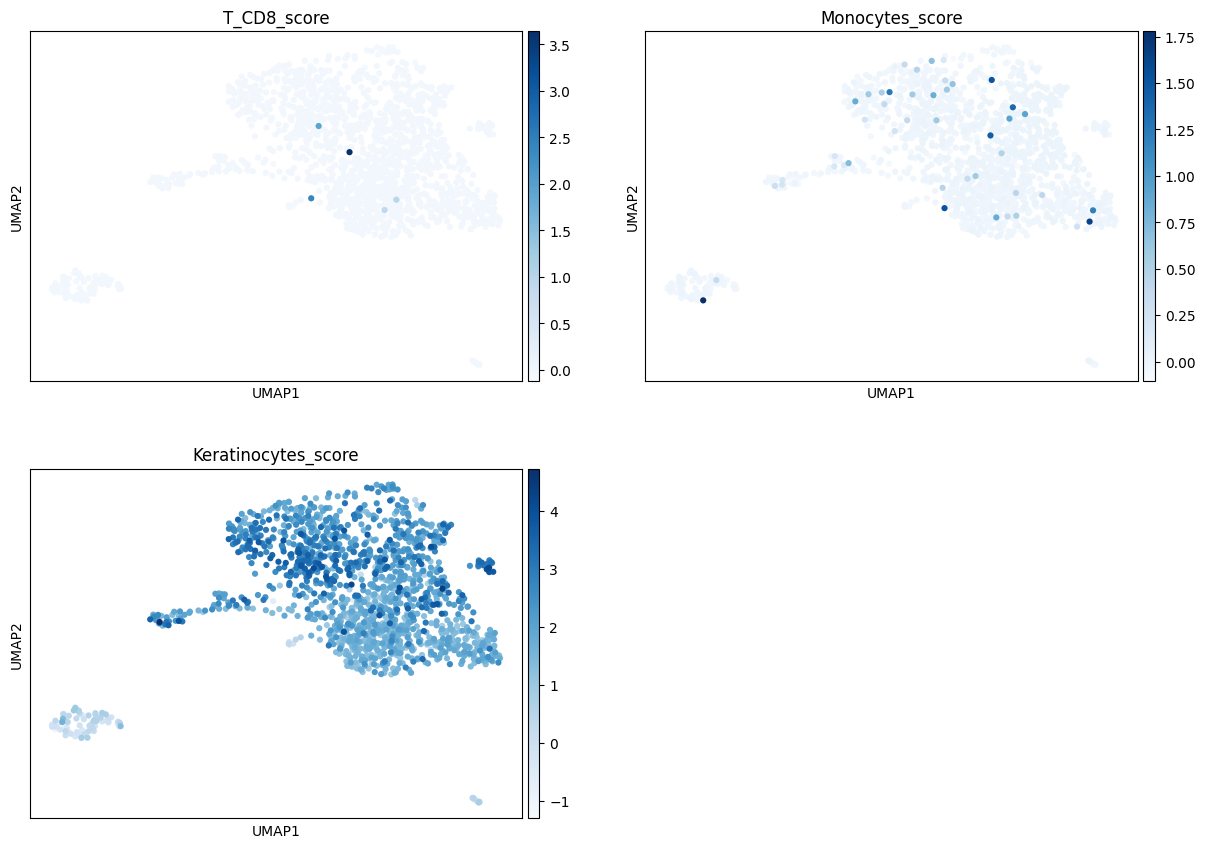

In [62]:
#   Cell Type Annotation Using Marker Genes
immune_markers = {
    'T_CD4': ['CD4', 'IL7R', 'CCR7'],
    'T_CD8': ['CD8A', 'CD8B', 'GZMB'],
    'T_reg': ['FOXP3', 'IL2RA', 'CTLA4'],
    'NK': ['GNLY', 'NKG7', 'KLRD1'],
    'B_cells': ['MS4A1', 'CD79A', 'IGHM'],
    'Plasma': ['IGHG1', 'MZB1', 'XBP1'],
    'Monocytes': ['CD14', 'LYZ', 'S100A9'],
    'Macrophages': ['CD68', 'CD163', 'C1QA'],
    'DC_myeloid': ['CD1C', 'FCER1A', 'CLEC10A'],
    'DC_plasmacytoid': ['LILRA4', 'GZMB', 'IRF7'],
    'Keratinocytes': ['KRT14', 'KRT5', 'KRT10'],
    'Melanocytes': ['TYR', 'TYRP1', 'DCT'],
    'Fibroblasts': ['COL1A1', 'COL3A1', 'PDGFRA'],
    'Endothelial': ['PECAM1', 'VWF', 'CDH5']
}

print("Scoring cell types...")
for cell_type, markers in immune_markers.items():
    present = [m for m in markers if m in adata.var_names]
    if present:
        sc.tl.score_genes(adata, present, score_name=f'{cell_type}_score')
        print(f"✓ Scored {cell_type} ({len(present)} markers)")
    else:
        print(f"✗ Skipped {cell_type} (no markers found)")

# Plot UMAP for key immune/skin populations
highlight_types = ['T_CD4', 'T_CD8', 'Monocytes', 'Keratinocytes']
highlight_scores = [f"{ct}_score" for ct in highlight_types if f"{ct}_score" in adata.obs.columns]

if highlight_scores:
    sc.pl.umap(adata, color=highlight_scores, ncols=2, cmap='Blues')

Tissue composition by cluster:
tissue  lesional  non-lesional
leiden                        
0          0.834         0.166
1          0.643         0.357
2          0.432         0.568
3          0.622         0.378
4          0.640         0.360
5          0.918         0.082
6          0.684         0.316
7          0.700         0.300
8          0.833         0.167


<Figure size 1000x600 with 0 Axes>

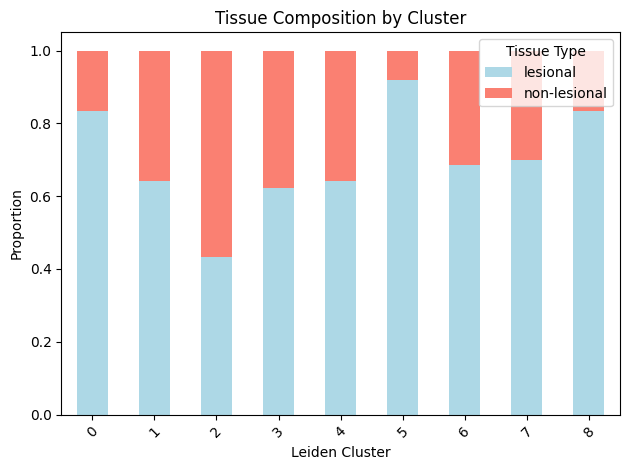

In [63]:
#   Cluster Composition Analysis (Lesional vs. Non-Lesional)
# Ensure Leiden clustering exists
if 'leiden' not in adata.obs:
    sc.tl.leiden(adata)

# Crosstab and proportions
print("Tissue composition by cluster:")
tissue_cluster_counts = pd.crosstab(adata.obs['leiden'], adata.obs['tissue'])
tissue_cluster_props = tissue_cluster_counts.div(tissue_cluster_counts.sum(axis=1), axis=0)
print(tissue_cluster_props.round(3))

# Bar plot
plt.figure(figsize=(10, 6))
tissue_cluster_props.plot(kind='bar', stacked=True, color=['lightblue', 'salmon'])
plt.title('Tissue Composition by Cluster')
plt.xlabel('Leiden Cluster')
plt.ylabel('Proportion')
plt.legend(title='Tissue Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Clusters enriched in lesional tissue: ['0', '1', '3', '4', '5', '6', '7', '8']
Analyzing DE in cluster 0


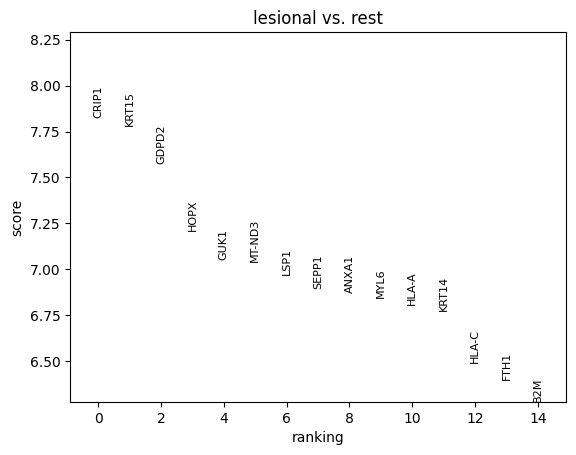


Top 10 upregulated genes in lesional vs non-lesional:
    names    scores     pvals_adj
0   CRIP1  7.827024  2.563711e-11
1   KRT15  7.781034  2.768756e-11
2   GDPD2  7.572028  1.131432e-10
3    HOPX  7.212300  1.411670e-09
4    GUK1  7.053383  3.646943e-09
5  MT-ND3  7.041999  3.646943e-09
6    LSP1  6.968688  5.472606e-09
7   SEPP1  6.894465  8.324256e-09
8   ANXA1  6.869877  8.993703e-09
9    MYL6  6.844832  9.823348e-09


In [64]:
#   Differential Expression Within Cell Types
# Identify lesional-enriched clusters
lesional_enriched_clusters = tissue_cluster_props[tissue_cluster_props['lesional'] > 0.6].index.tolist()
print(f"Clusters enriched in lesional tissue: {lesional_enriched_clusters}")

# DE analysis in the most lesional-enriched cluster
if lesional_enriched_clusters:
    target_cluster = lesional_enriched_clusters[0]
    print(f"Analyzing DE in cluster {target_cluster}")

    # Subset cluster
    adata_subset = adata[adata.obs['leiden'] == target_cluster].copy()
    
    if len(adata_subset.obs['tissue'].unique()) > 1:
        sc.tl.rank_genes_groups(adata_subset, groupby='tissue', method='wilcoxon')
        sc.pl.rank_genes_groups(adata_subset, n_genes=15, groups=['lesional'])
        
        de_results = sc.get.rank_genes_groups_df(adata_subset, group='lesional')
        print("\nTop 10 upregulated genes in lesional vs non-lesional:")
        print(de_results.head(10)[['names', 'scores', 'pvals_adj']])

In [65]:
#   Cytokine/Chemokine Expression Comparison
cytokine_comparison = pd.DataFrame()

for pathway, genes in available_genes.items():
    if any(x in pathway for x in ['cytokine', 'interferon', 'chemokine']):
        for gene in genes:
            if gene in adata.var_names:
                gene_expr = pd.DataFrame({
                    'expression': adata[:, gene].X.toarray().flatten(),
                    'tissue': adata.obs['tissue'],
                    'cluster': adata.obs['leiden']
                })

                lesional_mean = gene_expr[gene_expr['tissue'] == 'lesional']['expression'].mean()
                non_lesional_mean = gene_expr[gene_expr['tissue'] == 'non-lesional']['expression'].mean()

                cytokine_comparison = pd.concat([cytokine_comparison, pd.DataFrame({
                    'gene': [gene],
                    'pathway': [pathway],
                    'lesional_mean': [lesional_mean],
                    'non_lesional_mean': [non_lesional_mean],
                    'fold_change': [lesional_mean / (non_lesional_mean + 1e-10)]
                })], ignore_index=True)

cytokine_comparison = cytokine_comparison.sort_values('fold_change', ascending=False)
print("Top cytokines/chemokines upregulated in lesional tissue:")
print(cytokine_comparison.head(10).round(3))

Top cytokines/chemokines upregulated in lesional tissue:
     gene           pathway  lesional_mean  non_lesional_mean  fold_change
2    CCL5  other_chemokines         -0.025             -0.007        3.351
0  CXCL10  cxcr3_chemokines         -0.014             -0.039        0.355
3   CCL20  other_chemokines         -0.008             -0.051        0.158
4   CXCL8  other_chemokines          0.002             -0.064       -0.031
5   ISG15  type1_interferon          0.026             -0.092       -0.283
1    CCL2  other_chemokines         -0.003              0.007       -0.482


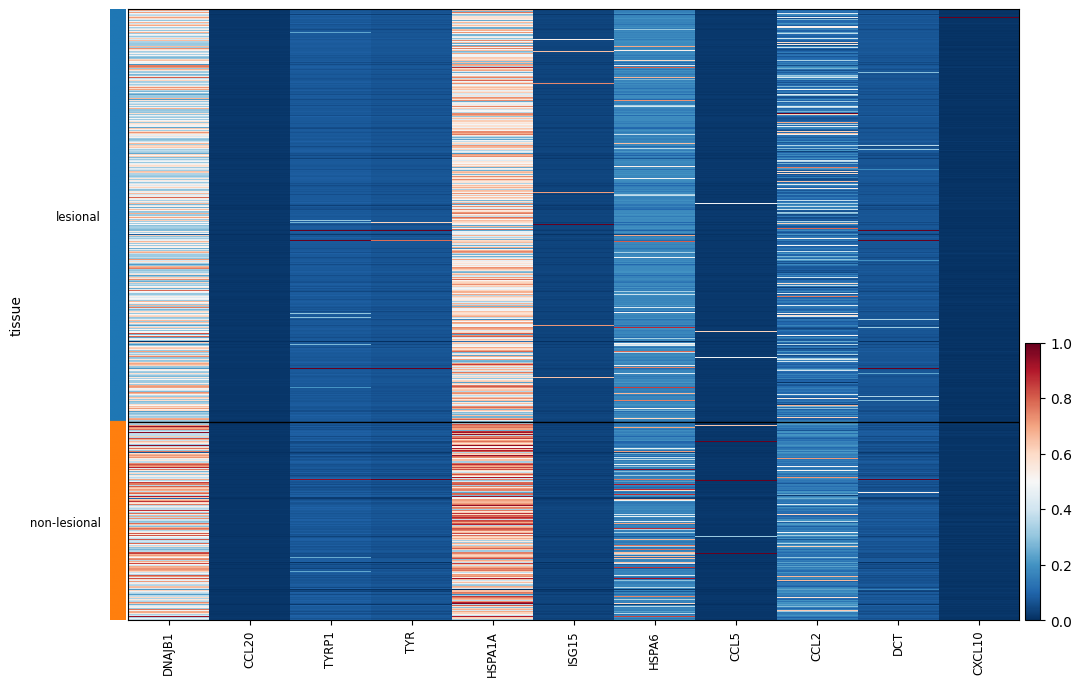

In [66]:
#   Heatmap of Top Vitiligo-Related Genes
adata.raw = adata.copy()

# Get top 3 genes per pathway that are in the dataset
top_genes = list({
    gene for genes in available_genes.values() 
    for gene in genes[:3] if gene in adata.var_names
})[:20]  # Limit to 20 genes

if top_genes:
    sc.pl.heatmap(
        adata,
        var_names=top_genes,
        groupby='tissue',
        figsize=(12, 8),
        cmap='RdBu_r',
        standard_scale='var'
    )
else:
    print("No matching top genes found in the dataset for heatmap.")

Cell types in lesional tissue: ['Keratinocytes', 'stress_response', 'DC_myeloid', 'other_chemokines', 'melanocyte_markers', 'type1_interferon', 'Melanocytes', 'Monocytes', 'cxcr3_chemokines', 'NK', 'T_CD8']


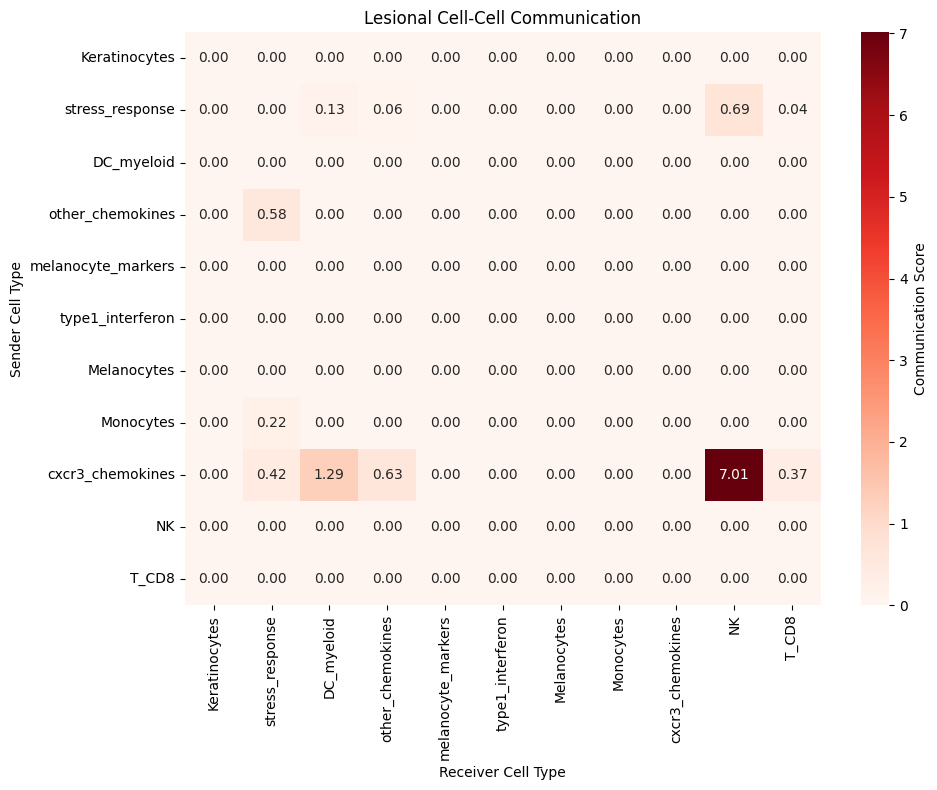

In [67]:
# Extract all score columns
score_cols = [col for col in adata.obs.columns if col.endswith('_score')]

# Assign cell type with highest score
adata.obs['cell_type'] = adata.obs[score_cols].idxmax(axis=1).str.replace('_score', '')
adata.obs['predicted_cell_type'] = adata.obs['cell_type']  # optional alias

lr_pairs = {
    'CXCL9_CXCR3': {'ligand': 'CXCL9', 'receptor': 'CXCR3', 'pathway': 'T cell recruitment'},
    'CXCL10_CXCR3': {'ligand': 'CXCL10', 'receptor': 'CXCR3', 'pathway': 'T cell recruitment'},
    'CXCL11_CXCR3': {'ligand': 'CXCL11', 'receptor': 'CXCR3', 'pathway': 'T cell recruitment'},
    'CCL2_CCR2': {'ligand': 'CCL2', 'receptor': 'CCR2', 'pathway': 'Monocyte recruitment'},
    'CCL5_CCR5': {'ligand': 'CCL5', 'receptor': 'CCR5', 'pathway': 'T cell activation'},
    'TNF_TNFRSF1A': {'ligand': 'TNF', 'receptor': 'TNFRSF1A', 'pathway': 'TNF signaling'},
    'IFNG_IFNGR1': {'ligand': 'IFNG', 'receptor': 'IFNGR1', 'pathway': 'IFN-gamma signaling'},
    'IL2_IL2RA': {'ligand': 'IL2', 'receptor': 'IL2RA', 'pathway': 'T cell activation'},
    'IL6_IL6R': {'ligand': 'IL6', 'receptor': 'IL6R', 'pathway': 'Inflammation'},
    'IL10_IL10RA': {'ligand': 'IL10', 'receptor': 'IL10RA', 'pathway': 'Anti-inflammation'},
    'CD80_CD28': {'ligand': 'CD80', 'receptor': 'CD28', 'pathway': 'T cell costimulation'},
    'CD86_CD28': {'ligand': 'CD86', 'receptor': 'CD28', 'pathway': 'T cell costimulation'},
    'PDCD1LG1_PDCD1': {'ligand': 'PDCD1LG1', 'receptor': 'PDCD1', 'pathway': 'Immune checkpoint'},
    'ICAM1_ITGAL': {'ligand': 'ICAM1', 'receptor': 'ITGAL', 'pathway': 'Cell adhesion'},
    'VCAM1_ITGA4': {'ligand': 'VCAM1', 'receptor': 'ITGA4', 'pathway': 'Cell adhesion'},
}

# Function to calculate score between cell types
def calculate_communication_score(adata, ligand_celltype, receptor_celltype, ligand_gene, receptor_gene):
    ligand_cells = adata[(adata.obs['tissue'] == 'lesional') & (adata.obs['cell_type'] == ligand_celltype)]
    receptor_cells = adata[(adata.obs['tissue'] == 'lesional') & (adata.obs['cell_type'] == receptor_celltype)]
    if len(ligand_cells) == 0 or len(receptor_cells) == 0:
        return 0
    if ligand_gene not in adata.var_names or receptor_gene not in adata.var_names:
        return 0
    ligand_expr = ligand_cells[:, ligand_gene].X.mean()
    receptor_expr = receptor_cells[:, receptor_gene].X.mean()
    return np.sqrt(ligand_expr * receptor_expr) if ligand_expr > 0 and receptor_expr > 0 else 0

lesional_cells = adata[adata.obs['tissue'] == 'lesional']
present_cell_types = lesional_cells.obs['cell_type'].unique().tolist()
print(f"Cell types in lesional tissue: {present_cell_types}")

# Compute communication matrix
comm_matrix = pd.DataFrame(0.0, index=present_cell_types, columns=present_cell_types)
detailed_interactions = []

for sender in present_cell_types:
    for receiver in present_cell_types:
        if sender != receiver:
            scores = []
            for pair, info in lr_pairs.items():
                score = calculate_communication_score(adata, sender, receiver, info['ligand'], info['receptor'])
                if score > 0:
                    scores.append(score)
                    detailed_interactions.append({
                        'sender': sender, 'receiver': receiver,
                        'ligand': info['ligand'], 'receptor': info['receptor'],
                        'pathway': info['pathway'], 'score': score
                    })
            comm_matrix.loc[sender, receiver] = np.mean(scores) if scores else 0

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(comm_matrix, annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Communication Score'})
plt.title("Lesional Cell-Cell Communication")
plt.xlabel("Receiver Cell Type")
plt.ylabel("Sender Cell Type")
plt.tight_layout()
plt.show()
 

In [68]:
# Create contingency table
celltype_tissue = pd.crosstab(adata.obs['cell_type'], adata.obs['tissue'])

# Run chi-square test
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(celltype_tissue)

# Print result
print(f"\nChi-square test: p-value = {p:.4e}")



Chi-square test: p-value = 6.2616e-10


✗ CD4_T_cells: No markers found in dataset
✓ CD8_T_cells: 1/5 markers available
✓ NK_cells: 1/5 markers available
✗ B_cells: No markers found in dataset
✓ Monocytes: 3/5 markers available
✗ Macrophages: No markers found in dataset
✓ Dendritic_cells: 3/4 markers available
✓ Keratinocytes: 3/5 markers available
✓ Melanocytes: 5/5 markers available
✗ Fibroblasts: No markers found in dataset
✗ Endothelial: No markers found in dataset
Cluster Purity Assessment:
  cluster   predicted_type  purity_score  n_cells
5       7      Melanocytes         8.451       10
7       5  Dendritic_cells         2.204       73
8       8         NK_cells         1.568        6
0       1    Keratinocytes         0.588      389
6       6    Keratinocytes         0.271       19
4       4    Keratinocytes         0.269       89
2       2    Keratinocytes         0.071      292
3       0      CD8_T_cells         0.053      471
1       3         NK_cells        -0.003      148


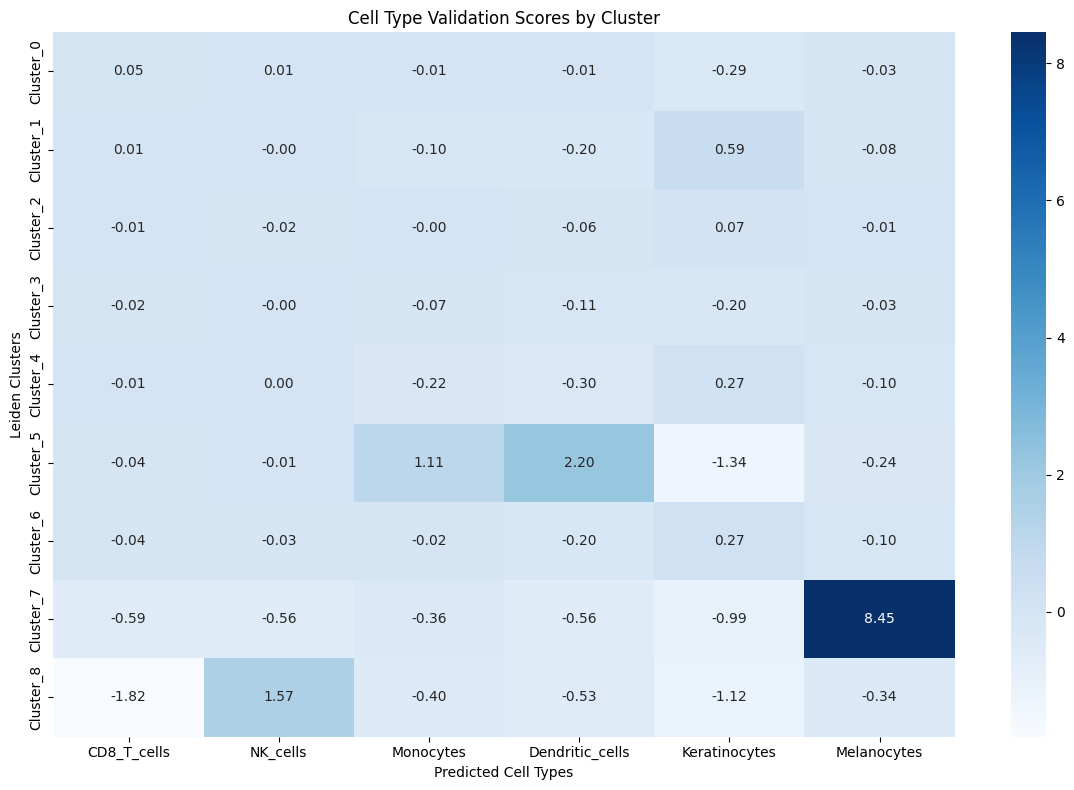

In [69]:
reference_markers = {
    'CD4_T_cells': ['CD4', 'IL7R', 'CCR7', 'LDHB'],
    'CD8_T_cells': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'PRF1'],
    'NK_cells': ['GNLY', 'NKG7', 'KLRD1', 'NCAM1', 'KLRF1'],
    'B_cells': ['MS4A1', 'CD79A', 'CD79B', 'IGHM', 'PAX5'],
    'Monocytes': ['CD14', 'LYZ', 'S100A9', 'FCGR3A', 'CSF1R'],
    'Macrophages': ['CD68', 'CD163', 'C1QA', 'C1QB', 'MSR1'],
    'Dendritic_cells': ['CD1C', 'FCER1A', 'CLEC10A', 'IRF8'],
    'Keratinocytes': ['KRT14', 'KRT5', 'KRT10', 'KRT1', 'SPRR1A'],
    'Melanocytes': ['TYR', 'TYRP1', 'DCT', 'MITF', 'PMEL'],
    'Fibroblasts': ['COL1A1', 'COL3A1', 'PDGFRA', 'DCN', 'LUM'],
    'Endothelial': ['PECAM1', 'VWF', 'CDH5', 'ENG', 'TEK']
}
 
for cell_type, markers in reference_markers.items():
    available = [m for m in markers if m in adata.var_names]
    if available:
        sc.tl.score_genes(adata, gene_list=available, score_name=f'{cell_type}_validation_score')
        print(f"✓ {cell_type}: {len(available)}/{len(markers)} markers available")
    else:
        print(f"✗ {cell_type}: No markers found in dataset")

 
validation_scores = [col for col in adata.obs.columns if 'validation_score' in col]
cluster_purity = pd.DataFrame()

for cluster in adata.obs['leiden'].unique():
    cluster_cells = adata.obs[adata.obs['leiden'] == cluster]
    mean_scores = cluster_cells[validation_scores].mean()
    dominant_type = mean_scores.idxmax().replace('_validation_score', '')
    purity_score = mean_scores.max()
    
    cluster_purity = pd.concat([cluster_purity, pd.DataFrame({
        'cluster': [cluster],
        'predicted_type': [dominant_type],
        'purity_score': [purity_score],
        'n_cells': [len(cluster_cells)]
    })], ignore_index=True)

cluster_purity = cluster_purity.sort_values('purity_score', ascending=False)
print("Cluster Purity Assessment:")
print(cluster_purity.round(3))
 
plt.figure(figsize=(12, 8))
score_matrix = pd.DataFrame()

for cluster in sorted(adata.obs['leiden'].unique()):
    cluster_cells = adata.obs[adata.obs['leiden'] == cluster]
    scores = cluster_cells[validation_scores].mean()
    scores.name = f'Cluster_{cluster}'
    score_matrix = pd.concat([score_matrix, scores], axis=1)

score_matrix.index = [idx.replace('_validation_score', '') for idx in score_matrix.index]

sns.heatmap(score_matrix.T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Cell Type Validation Scores by Cluster')
plt.xlabel('Predicted Cell Types')
plt.ylabel('Leiden Clusters')
plt.tight_layout()
plt.show()

Cell Type Proportions by Tissue:
predicted_cell_type  CD8_T_cells  Dendritic_cells  Keratinocytes  Melanocytes  \
tissue                                                                          
lesional                  0.0139           0.2554         0.3614       0.0891   
non-lesional              0.1211           0.0883         0.5277       0.0903   

predicted_cell_type  Monocytes  NK_cells  
tissue                                    
lesional                0.1010    0.1792  
non-lesional            0.0575    0.1150  

Infiltration Statistics (Top Enriched):
         cell_type  lesional_proportion  non_lesional_proportion  fold_change  \
1  Dendritic_cells               0.2554                   0.0883       2.8931   
4        Monocytes               0.1010                   0.0575       1.7565   
5         NK_cells               0.1792                   0.1150       1.5585   
3      Melanocytes               0.0891                   0.0903       0.9863   
2    Keratinocytes      

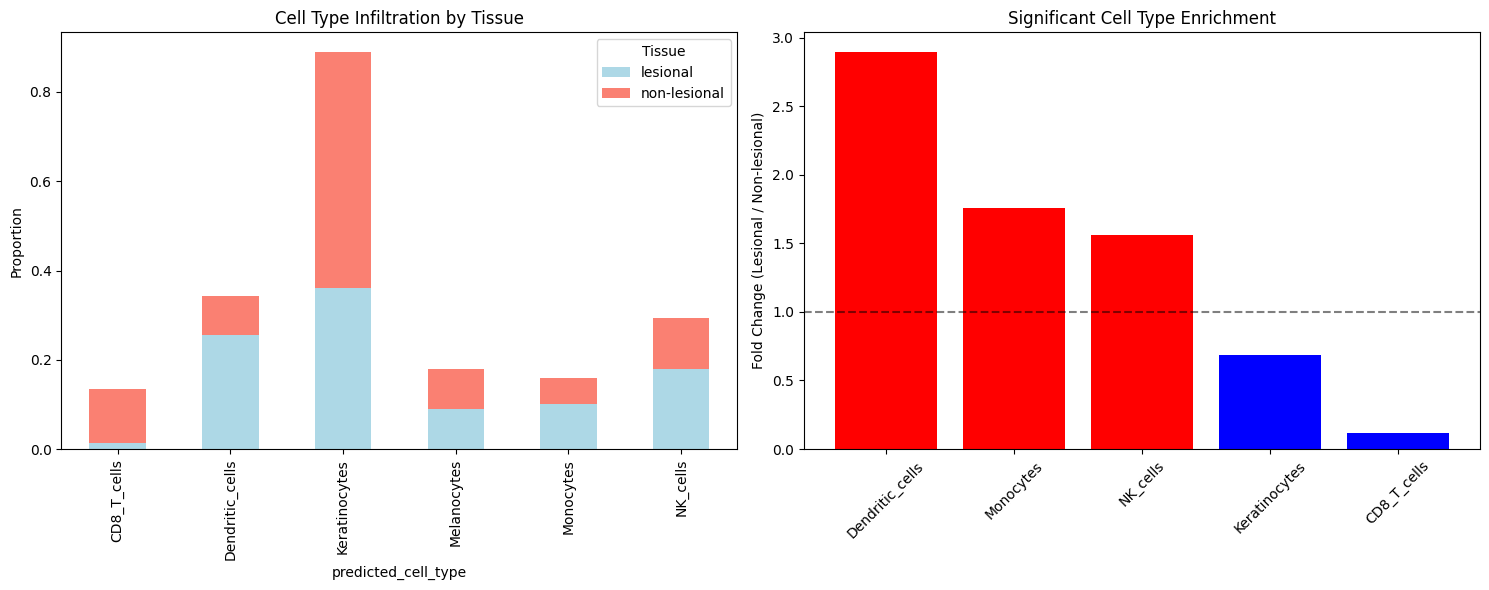

In [71]:
validation_scores = [col for col in adata.obs.columns if 'validation_score' in col]

if validation_scores:
    # Assign each cell the predicted type based on highest validation score
    adata.obs['predicted_cell_type'] = adata.obs[validation_scores].idxmax(axis=1)
    adata.obs['predicted_cell_type'] = adata.obs['predicted_cell_type'].str.replace('_validation_score', '')

    # Calculate cell type proportions by tissue
    infiltration_analysis = pd.crosstab(
        adata.obs['tissue'],
        adata.obs['predicted_cell_type'],
        normalize='index'
    )
    print("Cell Type Proportions by Tissue:")
    print(infiltration_analysis.round(4))

    # Run chi-squared tests and compute fold changes
    infiltration_stats = pd.DataFrame()

    for cell_type in infiltration_analysis.columns:
        lesional_prop = infiltration_analysis.loc['lesional', cell_type]
        non_lesional_prop = infiltration_analysis.loc['non-lesional', cell_type]

        lesional_cells = adata.obs[
            (adata.obs['tissue'] == 'lesional') &
            (adata.obs['predicted_cell_type'] == cell_type)
        ]
        non_lesional_cells = adata.obs[
            (adata.obs['tissue'] == 'non-lesional') &
            (adata.obs['predicted_cell_type'] == cell_type)
        ]

        # Build contingency table for presence/absence of this cell type in tissues
        contingency = pd.crosstab(
            adata.obs['tissue'],
            adata.obs['predicted_cell_type'] == cell_type
        )
        chi2, p_val, _, _ = stats.chi2_contingency(contingency)

        fold_change = lesional_prop / (non_lesional_prop + 1e-10)

        infiltration_stats = pd.concat([infiltration_stats, pd.DataFrame({
            'cell_type': [cell_type],
            'lesional_proportion': [lesional_prop],
            'non_lesional_proportion': [non_lesional_prop],
            'fold_change': [fold_change],
            'p_value': [p_val],
            'n_lesional': [len(lesional_cells)],
            'n_non_lesional': [len(non_lesional_cells)]
        })], ignore_index=True)

    # FDR correction
    _, infiltration_stats['p_adj'], _, _ = multipletests(
        infiltration_stats['p_value'], method='fdr_bh'
    )

    infiltration_stats = infiltration_stats.sort_values('fold_change', ascending=False)

    print("\nInfiltration Statistics (Top Enriched):")
    print(infiltration_stats.round(4))

    # -------------------
    # Visualization
    # -------------------

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Stacked bar plot of infiltration proportions
    infiltration_analysis.T.plot(
        kind='bar', stacked=True, ax=axes[0], color=['lightblue', 'salmon']
    )
    axes[0].set_title('Cell Type Infiltration by Tissue')
    axes[0].set_ylabel('Proportion')
    axes[0].legend(title='Tissue')

    # 2. Fold-change bar plot for significant cell types
    significant = infiltration_stats[infiltration_stats['p_adj'] < 0.05]
    bars = axes[1].bar(
        range(len(significant)),
        significant['fold_change'],
        color=['red' if fc > 1 else 'blue' for fc in significant['fold_change']]
    )
    axes[1].set_xticks(range(len(significant)))
    axes[1].set_xticklabels(significant['cell_type'], rotation=45)
    axes[1].axhline(1, color='black', linestyle='--', alpha=0.5)
    axes[1].set_ylabel('Fold Change (Lesional / Non-lesional)')
    axes[1].set_title('Significant Cell Type Enrichment')

    plt.tight_layout()
    plt.show()
 


Immune Score Comparison:
Lesional median: -0.0084
Non-lesional median: 0.0000
Mann-Whitney U p-value: 8.3553e-04


C:\Users\harsh\AppData\Local\Temp\ipykernel_18048\1090497316.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=adata.obs, x='tissue', y='immune_score', palette='Set2')


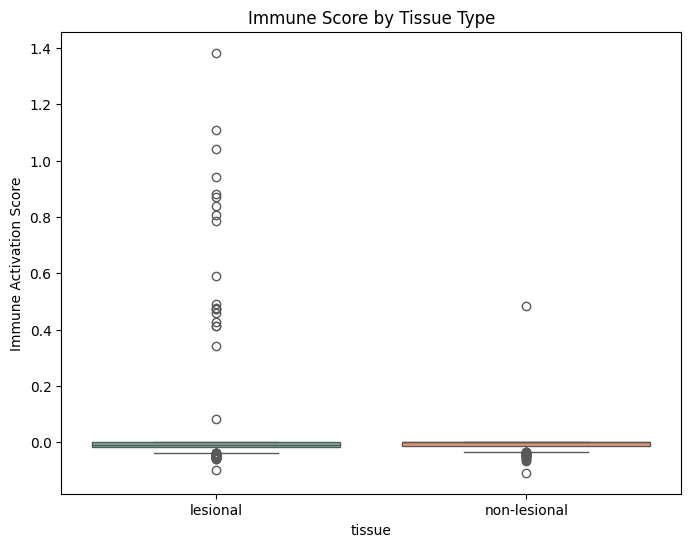

In [73]:
immune_pathways = [col for col in adata.obs.columns if any(
    x in col for x in ['th1_cytokines', 'th17_cytokines', 'cxcr3_chemokines', 'type1_interferon']
)]

if immune_pathways:
    # Calculate per-cell immune activation score
    adata.obs['immune_score'] = adata.obs[immune_pathways].mean(axis=1)

    # Compare scores between tissues
    lesional_scores = adata.obs[adata.obs['tissue'] == 'lesional']['immune_score']
    non_lesional_scores = adata.obs[adata.obs['tissue'] == 'non-lesional']['immune_score']

    u_stat, p_val = stats.mannwhitneyu(lesional_scores, non_lesional_scores)

    print(f"Immune Score Comparison:")
    print(f"Lesional median: {lesional_scores.median():.4f}")
    print(f"Non-lesional median: {non_lesional_scores.median():.4f}")
    print(f"Mann-Whitney U p-value: {p_val:.4e}")

    # Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=adata.obs, x='tissue', y='immune_score', palette='Set2')
    plt.title('Immune Score by Tissue Type')
    plt.ylabel('Immune Activation Score')
    plt.show()

Analyzing 18 pathways
Lesional network:
  Nodes: 18
  Edges: 21
  Density: 0.137
Non-lesional network:
  Nodes: 18
  Edges: 75
  Density: 0.490
Network Comparison:
         tissue  nodes  edges  density  avg_clustering  avg_degree  \
0      lesional     18     21    0.137           0.504       2.333   
1  non-lesional     18     75    0.490           0.722       8.333   

          top_central_pathway  
0  Dendritic_cells_validation  
1      CD8_T_cells_validation  


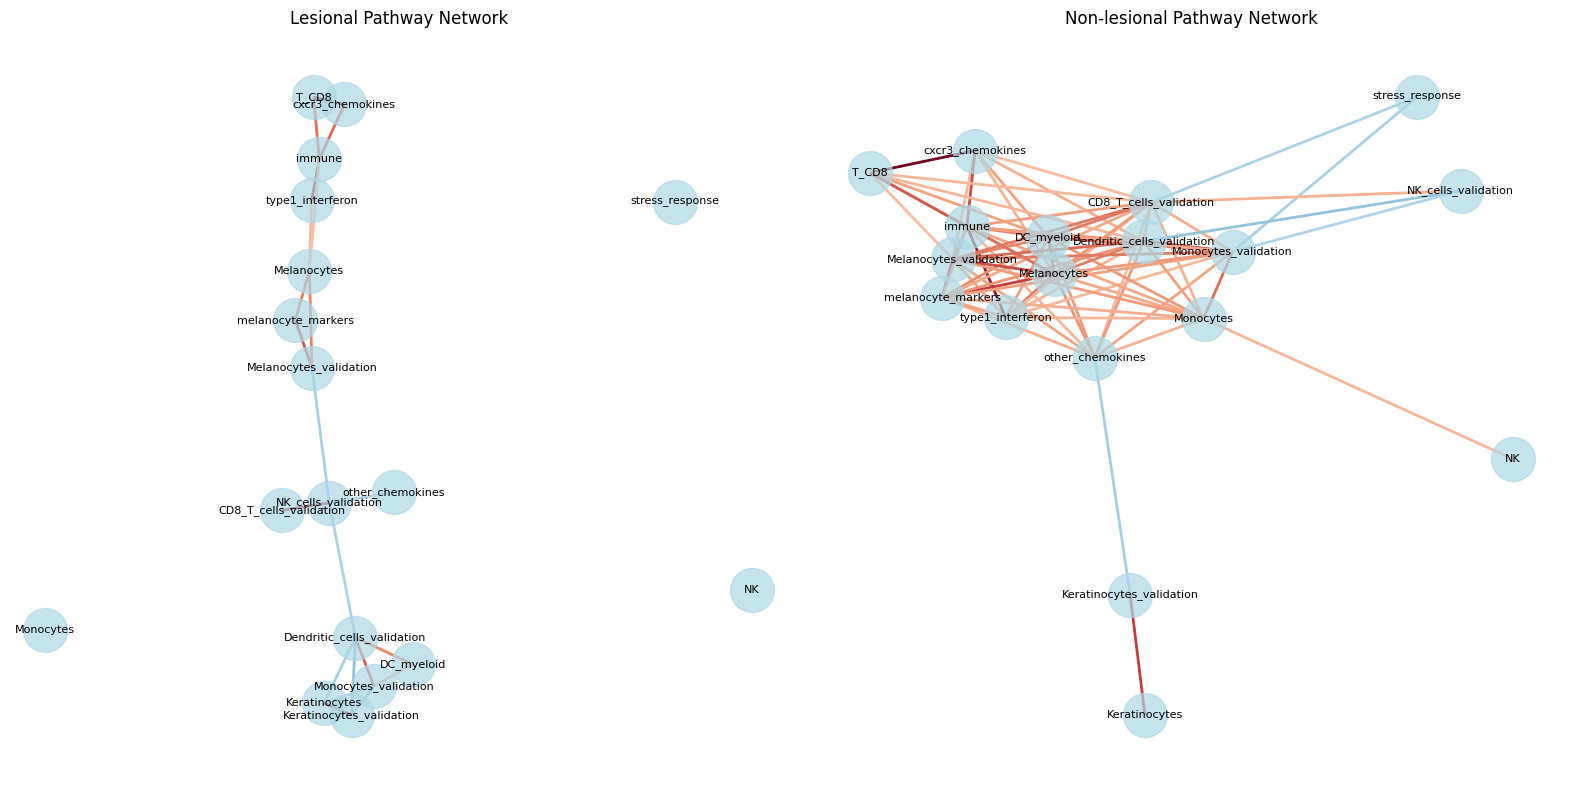

Top Hub Pathways:
          tissue                     pathway  degree_centrality  \
29  non-lesional      CD8_T_cells_validation             0.8235   
32  non-lesional  Dendritic_cells_validation             0.7647   
26  non-lesional                  DC_myeloid             0.7059   
28  non-lesional                 Melanocytes             0.7059   
31  non-lesional        Monocytes_validation             0.7059   
34  non-lesional      Melanocytes_validation             0.7059   
35  non-lesional                      immune             0.7059   
25  non-lesional                   Monocytes             0.6471   
19  non-lesional            other_chemokines             0.5882   
21  non-lesional          melanocyte_markers             0.5882   

    betweenness_centrality  closeness_centrality  
29                  0.1189                0.8095  
32                  0.0564                0.7727  
26                  0.0221                0.7391  
28                  0.0221              

In [113]:

pathway_scores = [col for col in adata.obs.columns if col.endswith('_score')]

if len(pathway_scores) < 3:
    print("Insufficient pathway scores for network analysis")
else:
    print(f"Analyzing {len(pathway_scores)} pathways")
 
    tissues = ['lesional', 'non-lesional']
    networks = {}

    for tissue in tissues:
        tissue_data = adata.obs[adata.obs['tissue'] == tissue][pathway_scores]
        corr_matrix = tissue_data.corr(method='spearman')

        G = nx.Graph()
        pathway_names = [p.replace('_score', '') for p in pathway_scores]
        G.add_nodes_from(pathway_names)

        threshold = 0.3  # Set correlation cutoff

        for i, p1 in enumerate(pathway_names):
            for j, p2 in enumerate(pathway_names):
                if i < j:
                    corr_val = corr_matrix.iloc[i, j]
                    if abs(corr_val) > threshold:
                        G.add_edge(p1, p2, weight=abs(corr_val), correlation=corr_val)

        networks[tissue] = G

        print(f"{tissue.capitalize()} network:")
        print(f"  Nodes: {G.number_of_nodes()}")
        print(f"  Edges: {G.number_of_edges()}")
        print(f"  Density: {nx.density(G):.3f}")
 

    

    network_comparison = pd.DataFrame()

    for tissue, G in networks.items():
        if G.number_of_edges() > 0:
            avg_clustering = nx.average_clustering(G)
            avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
            centrality = nx.degree_centrality(G)
            top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:3]

            network_comparison = pd.concat([network_comparison, pd.DataFrame({
                'tissue': [tissue],
                'nodes': [G.number_of_nodes()],
                'edges': [G.number_of_edges()],
                'density': [nx.density(G)],
                'avg_clustering': [avg_clustering],
                'avg_degree': [avg_degree],
                'top_central_pathway': [top_central[0][0] if top_central else 'None']
            })], ignore_index=True)

    print("Network Comparison:")
    print(network_comparison.round(3))
 
 

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    for idx, (tissue, G) in enumerate(networks.items()):
        if G.number_of_edges() > 0:
            pos = nx.spring_layout(G, seed=42)
            nx.draw_networkx_nodes(G, pos, ax=axes[idx], node_color='lightblue',
                                   node_size=1000, alpha=0.7)

            edges = G.edges()
            edge_colors = [G[u][v]['correlation'] for u, v in edges]

            nx.draw_networkx_edges(G, pos, ax=axes[idx], edge_color=edge_colors,
                                   edge_cmap=plt.cm.RdBu_r, edge_vmin=-1, edge_vmax=1,
                                   width=2)

            nx.draw_networkx_labels(G, pos, ax=axes[idx], font_size=8)
            axes[idx].set_title(f'{tissue.capitalize()} Pathway Network')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f'No significant\ncorrelations in\n{tissue}',
                           ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'{tissue.capitalize()} Pathway Network')

    plt.tight_layout()
    plt.show()


    hub_analysis = pd.DataFrame()

    for tissue, G in networks.items():
        if G.number_of_edges() > 0:
            degree_cent = nx.degree_centrality(G)
            betweenness_cent = nx.betweenness_centrality(G)
            closeness_cent = nx.closeness_centrality(G)

            for pathway in G.nodes():
                hub_analysis = pd.concat([hub_analysis, pd.DataFrame({
                    'tissue': [tissue],
                    'pathway': [pathway],
                    'degree_centrality': [degree_cent[pathway]],
                    'betweenness_centrality': [betweenness_cent[pathway]],
                    'closeness_centrality': [closeness_cent[pathway]]
                })], ignore_index=True)

    if not hub_analysis.empty:
        print("Top Hub Pathways:")
        print(hub_analysis.nlargest(10, 'degree_centrality').round(4))

In [115]:
sample_level_data = pd.DataFrame()
pathway_scores = [col for col in adata.obs.columns if col.endswith('_score')]

 
for cell in adata.obs.index:
    row = adata.obs.loc[cell]
    sample_metrics = {
        'sample_id': cell,
        'tissue_type': row['tissue'],
        'n_cells': 1,
        'immune_activation': row[pathway_scores].mean() if pathway_scores else 0
    }
    for pathway in pathway_scores:
        sample_metrics[pathway] = row[pathway]
    sample_level_data = pd.concat([sample_level_data, pd.DataFrame([sample_metrics])], ignore_index=True)

print(f"Analyzed {len(sample_level_data)} cells")
print("Summary by tissue type:")
print(sample_level_data.groupby('tissue_type').agg({
    'immune_activation': ['mean', 'std'],
    'n_cells': 'sum'
}).round(3))
 
 

if 'immune_activation' in sample_level_data.columns:
    lesional_data = sample_level_data[sample_level_data['tissue_type'] == 'lesional']
    
    if len(lesional_data) > 0:
        thresholds = lesional_data['immune_activation'].quantile([0.25, 0.5, 0.75])

        def assign_severity(score):
            if score <= thresholds[0.25]:
                return 'Mild'
            elif score <= thresholds[0.5]:
                return 'Moderate'
            elif score <= thresholds[0.75]:
                return 'Severe'
            else:
                return 'Very_Severe'

        sample_level_data['severity'] = sample_level_data['immune_activation'].apply(assign_severity)
        print("Severity Distribution:")
        print(sample_level_data['severity'].value_counts())

        # Correlation of severity with pathways
        severity_encoding = {'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very_Severe': 4}
        sample_level_data['severity_numeric'] = sample_level_data['severity'].map(severity_encoding)

        pathway_severity_corr = pd.DataFrame()
        for pathway in pathway_scores:
            corr, p_val = stats.spearmanr(sample_level_data['severity_numeric'], sample_level_data[pathway])
            pathway_severity_corr = pd.concat([pathway_severity_corr, pd.DataFrame({
                'pathway': [pathway.replace('_score', '')],
                'correlation': [corr],
                'p_value': [p_val]
            })], ignore_index=True)

        pathway_severity_corr = pathway_severity_corr.sort_values('correlation', ascending=False)
        print("\nPathway-Severity Correlations:")
        print(pathway_severity_corr.round(4))


Analyzed 1497 cells
Summary by tissue type:
             immune_activation        n_cells
                          mean    std     sum
tissue_type                                  
lesional                 0.120  0.112    1010
non-lesional             0.163  0.112     487
Severity Distribution:
severity
Very_Severe    458
Severe         407
Moderate       335
Mild           297
Name: count, dtype: int64

Pathway-Severity Correlations:
                       pathway  correlation  p_value
9                Keratinocytes       0.5265   0.0000
15    Keratinocytes_validation       0.4788   0.0000
4              stress_response       0.4529   0.0000
12         NK_cells_validation       0.2300   0.0000
8                   DC_myeloid       0.2293   0.0000
11      CD8_T_cells_validation       0.1492   0.0000
7                    Monocytes       0.1462   0.0000
17                      immune       0.1217   0.0000
3           melanocyte_markers       0.1173   0.0000
2             type1_interferon

Feature Importance for Tissue Type Prediction:
                       pathway  importance
4              stress_response      0.1526
11      CD8_T_cells_validation      0.1220
12         NK_cells_validation      0.0862
1             other_chemokines      0.0711
8                   DC_myeloid      0.0660
14  Dendritic_cells_validation      0.0616
9                Keratinocytes      0.0610
3           melanocyte_markers      0.0609
13        Monocytes_validation      0.0562
15    Keratinocytes_validation      0.0504
16      Melanocytes_validation      0.0504
10                 Melanocytes      0.0503
7                    Monocytes      0.0342
17                      immune      0.0224
2             type1_interferon      0.0178
5                        T_CD8      0.0135
0             cxcr3_chemokines      0.0124
6                           NK      0.0111

Cross-validation accuracy: 0.840 ± 0.015


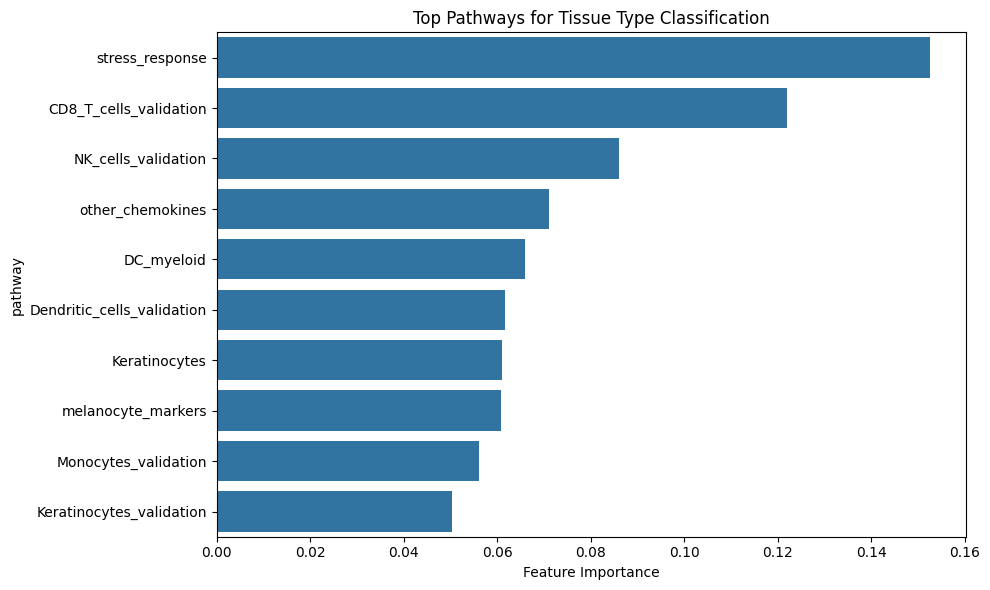

In [77]:
feature_cols = [col for col in adata.obs.columns if col.endswith('_score')]

if len(feature_cols) >= 3:
    X = adata.obs[feature_cols].fillna(0)
    y = adata.obs['tissue']

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)

    # Feature importance
    feature_importance = pd.DataFrame({
        'pathway': [col.replace('_score', '') for col in feature_cols],
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Feature Importance for Tissue Type Prediction:")
    print(feature_importance.round(4))

    # Cross-validation
    from sklearn.model_selection import cross_val_score
    cv_scores = cross_val_score(rf_model, X, y, cv=5)
    print(f"\nCross-validation accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    # Plot top 10 features
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='pathway')
    plt.title('Top Pathways for Tissue Type Classification')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

In [117]:
 
if isinstance(adata.uns.get("iroot", None), str):
    del adata.uns["iroot"]


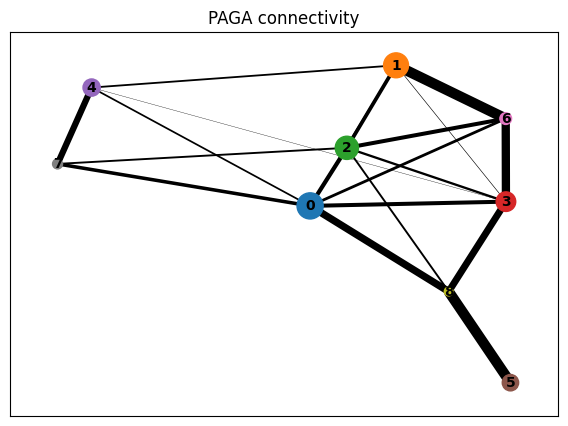

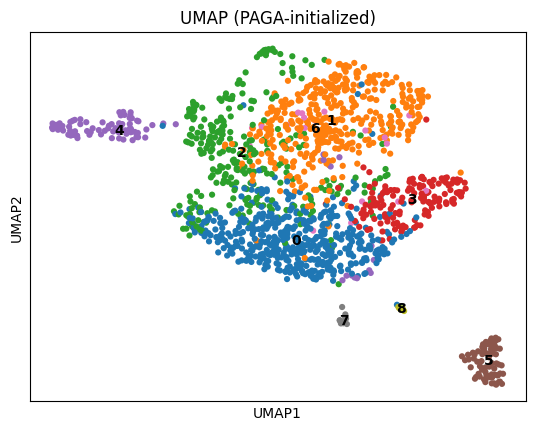

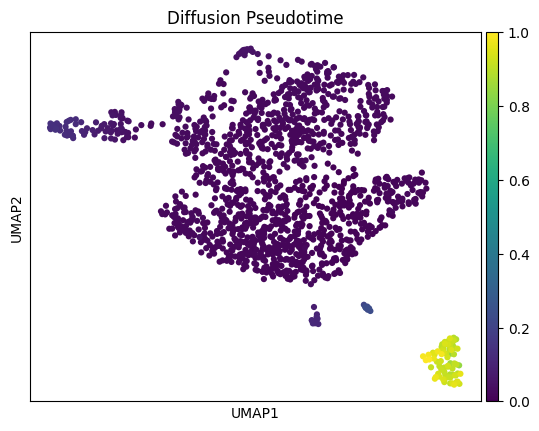

In [119]:
  
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10)

 
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, threshold=0.03, title="PAGA connectivity", show=True)

 
sc.tl.umap(adata, init_pos='paga')
sc.pl.umap(adata, color=['leiden'], title='UMAP (PAGA-initialized)', legend_loc='on data')

 
root_cell_name = adata.obs_names[adata.obs['leiden'] == '2'][0]
adata.uns['iroot'] = adata.obs_names.get_loc(root_cell_name)

 
sc.tl.dpt(adata)
sc.pl.umap(adata, color='dpt_pseudotime', cmap='viridis', title='Diffusion Pseudotime')



In [80]:
 
pathway_stats = pd.DataFrame()

for col in [c for c in adata.obs.columns if c.endswith('_score')]:
    l_scores = adata.obs[adata.obs['tissue'] == 'lesional'][col]
    nl_scores = adata.obs[adata.obs['tissue'] == 'non-lesional'][col]
    
    u_stat, p_val = stats.mannwhitneyu(l_scores, nl_scores, alternative='two-sided')
    effect_size = 1 - (2 * u_stat) / (len(l_scores) * len(nl_scores))
    
    pathway_stats = pd.concat([pathway_stats, pd.DataFrame({
        'pathway': [col.replace('_score', '')],
        'lesional_median': [l_scores.median()],
        'non_lesional_median': [nl_scores.median()],
        'fold_change': [l_scores.median() / (nl_scores.median() + 1e-10)],
        'u_statistic': [u_stat],
        'effect_size': [effect_size],
        'p_value': [p_val]
    })], ignore_index=True)

_, pathway_stats['p_adj'], _, _ = multipletests(pathway_stats['p_value'], method='fdr_bh')
pathway_stats = pathway_stats.sort_values('p_adj')
print(pathway_stats.round(4).head(10))

                       pathway  lesional_median  non_lesional_median  \
4              stress_response           0.2002               0.8806   
12         NK_cells_validation           0.0032               0.0100   
9                Keratinocytes           1.6891               2.1115   
11      CD8_T_cells_validation          -0.0111              -0.0013   
14  Dendritic_cells_validation          -0.0368              -0.1354   
15    Keratinocytes_validation          -0.1501               0.1045   
13        Monocytes_validation          -0.0577              -0.1148   
17                      immune          -0.0084               0.0000   
10                 Melanocytes          -0.0347              -0.0305   
7                    Monocytes          -0.0191              -0.0173   

     fold_change  u_statistic  effect_size  p_value   p_adj  
4   2.273000e-01     147716.0       0.3994   0.0000  0.0000  
12  3.142000e-01     156528.0       0.3635   0.0000  0.0000  
9   7.999000e-01     

In [81]:
 
# Wilcoxon test for DE genes across tissue
print("Gene-level differential expression (Tissue-based):")
adata_de = adata.copy()
sc.tl.rank_genes_groups(adata_de, groupby='tissue', method='wilcoxon', key_added='tissue_de', use_raw=True)
de_results = sc.get.rank_genes_groups_df(adata_de, group='lesional', key='tissue_de')
print(de_results[['names', 'scores', 'logfoldchanges', 'pvals_adj']].head(15))

# Permutation test for top 5 pathways
def permutation_test(group1, group2, n=1000):
    observed = np.median(group1) - np.median(group2)
    combined = np.concatenate([group1, group2])
    n1 = len(group1)
    diffs = [np.median(np.random.permutation(combined)[:n1]) - np.median(np.random.permutation(combined)[n1:])
             for _ in range(n)]
    return observed, np.mean(np.abs(diffs) >= np.abs(observed))

print("\nPermutation test for top 5 pathways:")
for _, row in pathway_stats.head(5).iterrows():
    score_col = f"{row['pathway']}_score"
    lesional_vals = adata.obs[adata.obs['tissue'] == 'lesional'][score_col].values
    non_lesional_vals = adata.obs[adata.obs['tissue'] == 'non-lesional'][score_col].values
    diff, p_perm = permutation_test(lesional_vals, non_lesional_vals)
    print(f"{row['pathway']}: Wilcoxon p={row['p_adj']:.4f}, Permutation p={p_perm:.4f}")

Gene-level differential expression (Tissue-based):


C:\Users\harsh\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\harsh\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


             names     scores  logfoldchanges     pvals_adj
0          TRG-AS1  16.979227       -2.098191  1.968834e-61
1    RP11-1000B6.5  16.850906       -2.138870  6.613136e-61
2          FAM151B  16.823023       -6.090475  6.619794e-61
3     RP11-44N11.2  16.778931             NaN  1.000845e-60
4             DNA2  16.778547             NaN  1.000845e-60
5            GDPD1  16.703318        1.467597  2.066254e-60
6            ACOT4  16.688896             NaN  2.428618e-60
7   RP11-379K17.12  16.668350             NaN  3.128105e-60
8             JPH1  16.665224       -4.735849  3.128105e-60
9     RP11-73G16.2  16.636702       -3.277286  4.198525e-60
10          ZNF461  16.617815             NaN  5.451217e-60
11            GPX7  16.606585             NaN  5.476809e-60
12           GDPD3  16.606073       -1.642139  5.476809e-60
13           FSIP2  16.603138        1.867236  5.511718e-60
14         ANKDD1A  16.593822        0.868293  6.179542e-60

Permutation test for top 5 pathways:
st

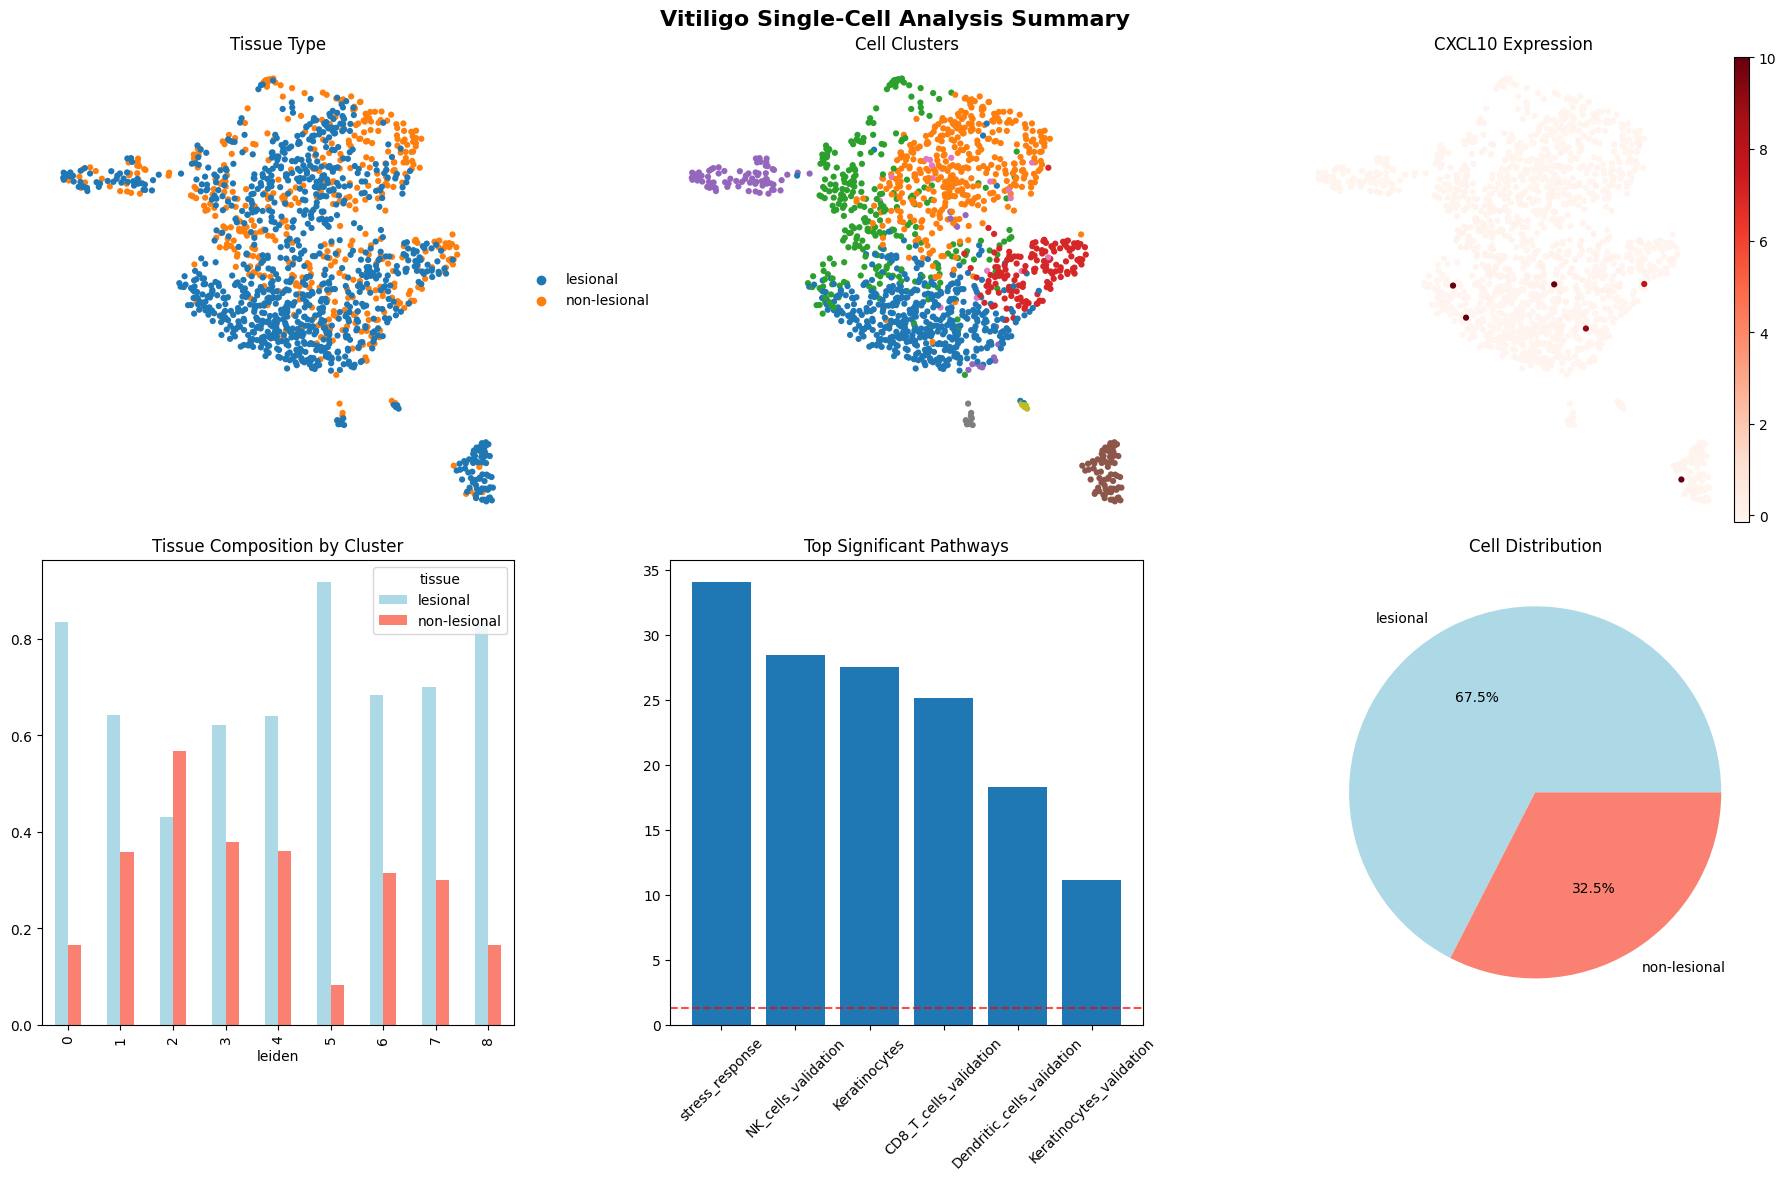

In [82]:
 
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Vitiligo Single-Cell Analysis Summary', fontsize=16, fontweight='bold')

sc.pl.umap(adata, color='tissue', ax=axes[0, 0], frameon=False, show=False)
axes[0, 0].set_title('Tissue Type')

sc.pl.umap(adata, color='leiden', ax=axes[0, 1], frameon=False, show=False, legend_loc=None)
axes[0, 1].set_title('Cell Clusters')

if 'IFNG' in adata.var_names:
    sc.pl.umap(adata, color='IFNG', ax=axes[0, 2], frameon=False, show=False, cmap='Reds')
    axes[0, 2].set_title('IFNG Expression')
else:
    top_gene = list(available_genes.values())[0][0]
    sc.pl.umap(adata, color=top_gene, ax=axes[0, 2], frameon=False, show=False, cmap='Reds')
    axes[0, 2].set_title(f'{top_gene} Expression')

tissue_cluster_props.plot(kind='bar', ax=axes[1, 0], color=['lightblue', 'salmon'])
axes[1, 0].set_title('Tissue Composition by Cluster')

if not pathway_stats.empty:
    bars = axes[1, 1].bar(range(6), -np.log10(pathway_stats['p_adj'].head(6)))
    axes[1, 1].set_xticks(range(6))
    axes[1, 1].set_xticklabels(pathway_stats['pathway'].head(6), rotation=45)
    axes[1, 1].axhline(-np.log10(0.05), color='red', linestyle='--', alpha=0.7)
    axes[1, 1].set_title('Top Significant Pathways')

tissue_counts = adata.obs['tissue'].value_counts()
axes[1, 2].pie(tissue_counts.values, labels=tissue_counts.index, autopct='%1.1f%%', colors=['lightblue', 'salmon'])
axes[1, 2].set_title('Cell Distribution')

plt.tight_layout()
plt.show()

In [83]:
 
# Extract all score columns
score_cols = [col for col in adata.obs.columns if col.endswith('_score')]

# Assign cell type with highest score
adata.obs['cell_type'] = adata.obs[score_cols].idxmax(axis=1).str.replace('_score', '')

# Check distribution
print("Cell type distribution:")
print(adata.obs['cell_type'].value_counts())

# Crosstab cell type vs tissue
celltype_tissue = pd.crosstab(adata.obs['cell_type'], adata.obs['tissue'])
celltype_tissue_props = celltype_tissue.div(celltype_tissue.sum(axis=1), axis=0)

print("\nProportion of each cell type by tissue:")
print(celltype_tissue_props.round(3))

Cell type distribution:
cell_type
Keratinocytes                 1280
stress_response                107
Dendritic_cells_validation      36
Monocytes_validation            24
DC_myeloid                      23
Melanocytes_validation          11
CD8_T_cells_validation           5
other_chemokines                 3
type1_interferon                 3
NK_cells_validation              3
cxcr3_chemokines                 2
Name: count, dtype: int64

Proportion of each cell type by tissue:
tissue                      lesional  non-lesional
cell_type                                         
CD8_T_cells_validation         0.600         0.400
DC_myeloid                     0.957         0.043
Dendritic_cells_validation     0.944         0.056
Keratinocytes                  0.682         0.318
Melanocytes_validation         0.727         0.273
Monocytes_validation           0.708         0.292
NK_cells_validation            1.000         0.000
cxcr3_chemokines               1.000         0.000
othe